# Multi-Label Classification with MLP

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from anime_classification import MultiLabelClassifier, Adam, Trainer

## Load Vectorized Synopsis/Genre Data

In [2]:
synop_vec = pd.read_csv('synopsis_vector.csv')
synop_vec.head()

,MAL_ID,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,1,-0.114563,-3.921875,0.508789,1.326172,2.681641,1.789062,-1.769531,-1.250977,-1.898438,...,0.863770,-0.738281,-1.119141,-0.729980,1.062500,1.274414,-0.247559,1.378906,1.920898,2.222656
1,5,2.312500,-2.361328,-0.013504,2.705078,1.199219,3.171875,-1.360352,-2.603516,-1.960938,...,0.493652,-0.946777,-0.937988,-0.260986,2.085938,1.500000,-0.222168,0.646973,2.218750,0.959961
2,6,-0.225952,-2.601562,-0.183105,2.042969,1.671875,1.951172,-1.368164,-2.917969,-0.161377,...,-1.435547,-1.021484,-2.537109,-2.455078,2.013672,1.943359,0.622559,1.703125,2.359375,1.231445
3,7,0.842773,-0.527344,0.271484,0.753906,1.575195,2.496094,-1.652344,-2.703125,-2.271484,...,-0.367676,-1.789062,-1.804688,-2.474609,2.878906,0.426025,-0.582520,3.107422,0.837402,1.043945
4,8,1.521484,-2.650391,0.423584,1.816406,2.029297,1.696289,0.607910,-1.335938,-1.022461,...,1.649414,-1.704102,-2.476562,-4.484375,1.402344,0.638184,0.058777,1.250977,2.457031,2.515625


In [3]:
genre_vec = pd.read_csv('genre.csv')
genre_vec.head()

,MAL_ID,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,1,1,1,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1,5,1,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2,6,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,8,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


## Split Train-Test Set

In [4]:
synop_cols = synop_vec.columns.drop('MAL_ID').values
genre_cols = genre_vec.columns.drop('MAL_ID').values

In [5]:
full_vec = pd.merge(synop_vec, genre_vec)
full_vec.head()

,MAL_ID,0,1,2,3,4,5,6,7,8,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,1,-0.114563,-3.921875,0.508789,1.326172,2.681641,1.789062,-1.769531,-1.250977,-1.898438,...,0,0,1,0,0,0,0,0,0,0
1,5,2.312500,-2.361328,-0.013504,2.705078,1.199219,3.171875,-1.360352,-2.603516,-1.960938,...,0,0,1,0,0,0,0,0,0,0
2,6,-0.225952,-2.601562,-0.183105,2.042969,1.671875,1.951172,-1.368164,-2.917969,-0.161377,...,0,0,0,0,0,0,0,0,0,0
3,7,0.842773,-0.527344,0.271484,0.753906,1.575195,2.496094,-1.652344,-2.703125,-2.271484,...,0,0,0,0,0,1,0,0,0,0
4,8,1.521484,-2.650391,0.423584,1.816406,2.029297,1.696289,0.607910,-1.335938,-1.022461,...,0,0,0,0,0,1,0,0,0,0


In [6]:
# random shuffle and re-index
full_vec = full_vec.sample(frac=1).reset_index(drop=True)
full_vec.head()

,MAL_ID,0,1,2,3,4,5,6,7,8,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,1699,1.656250,-1.757812,0.069824,1.344727,2.158203,2.578125,-2.080078,-1.563477,-1.580078,...,0,0,0,0,0,0,0,0,0,0
1,5572,-2.308594,-2.591797,1.899414,-0.343506,-0.736816,3.375000,-1.614258,-1.548828,-0.141846,...,0,0,0,0,0,0,0,0,0,0
2,37986,3.447266,-1.507812,-3.267578,-1.221680,3.804688,2.013672,-2.408203,-1.073242,-2.335938,...,0,0,0,0,0,0,0,0,0,0
3,10237,1.181641,-5.640625,2.412109,2.119141,4.117188,4.593750,-1.825195,-1.942383,-1.727539,...,0,0,0,0,0,0,0,0,0,0
4,31498,-0.902832,-3.273438,-0.698730,0.289307,2.007812,-1.078125,-1.535156,-0.404541,-3.009766,...,0,1,0,0,0,0,0,0,0,0


In [7]:
# split dataframe to train-test numpy array
train_ratio = 0.95
num_train = int(len(full_vec) * train_ratio)

x_train = full_vec[synop_cols][:num_train].values
t_train = full_vec[genre_cols][:num_train].values
id_train = full_vec['MAL_ID'][num_train:].values

x_test = full_vec[synop_cols][num_train:].values
t_test = full_vec[genre_cols][num_train:].values
id_test = full_vec['MAL_ID'][num_train:].values

del synop_vec, genre_vec, full_vec

In [8]:
# standardization
x_train_mean = x_train.mean(axis=0)
x_train_std  = x_train.std(axis=0)

x_train = (x_train - x_train_mean) / x_train_std
x_test  = (x_test  - x_train_mean) / x_train_std

## Define Model

In [9]:
input_size  = len(synop_cols)
output_size = len(genre_cols)

model = MultiLabelClassifier(input_size=input_size,
                             hidden_size_list=[50],
                             output_size=output_size,
                             use_dropout=True,
                             dropout_ratio=0.5,
                             use_batchnorm=True,
                             use_focal_loss=True,
                             focal_gamma=0.5)
model.summary()

------------------------------------------------------------
Affine(input_size=100, output_size=50, weight_init=he)
------------------------------------------------------------
BatchNormalization(size_layer=50)
------------------------------------------------------------
Relu()
------------------------------------------------------------
Dropout(dropout_ratio=0.5)
------------------------------------------------------------
Affine(input_size=50, output_size=43, weight_init=xavier)
------------------------------------------------------------
FocalLoss(gamma=0.5)
------------------------------------------------------------


In [10]:
optimizer = Adam(lr=0.001)
trainer = Trainer(model, optimizer)

## Train Model

In [11]:
num_epochs = 20
batch_size = 100

trainer.fit(x_train, t_train, x_test, t_test, 
            max_epoch=num_epochs, 
            batch_size=batch_size)

| epoch   1 | time   0[s] | train loss 11.51 | val loss 11.46
| epoch   2 | time   0[s] | train loss 8.52 | val loss 8.67
| epoch   3 | time   0[s] | train loss 8.49 | val loss 8.77
| epoch   4 | time   1[s] | train loss 8.79 | val loss 9.12
| epoch   5 | time   1[s] | train loss 8.98 | val loss 9.33
| epoch   6 | time   1[s] | train loss 9.06 | val loss 9.42
| epoch   7 | time   2[s] | train loss 9.05 | val loss 9.41
| epoch   8 | time   2[s] | train loss 9.03 | val loss 9.41
| epoch   9 | time   2[s] | train loss 8.98 | val loss 9.34
| epoch  10 | time   3[s] | train loss 8.97 | val loss 9.34
| epoch  11 | time   3[s] | train loss 8.92 | val loss 9.30
| epoch  12 | time   3[s] | train loss 8.83 | val loss 9.22
| epoch  13 | time   4[s] | train loss 8.79 | val loss 9.20
| epoch  14 | time   4[s] | train loss 8.79 | val loss 9.20
| epoch  15 | time   4[s] | train loss 8.72 | val loss 9.14
| epoch  16 | time   4[s] | train loss 8.74 | val loss 9.16
| epoch  17 | time   4[s] | train loss

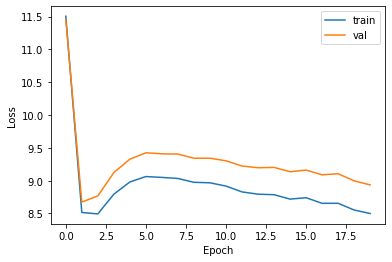

In [12]:
trainer.plot()

In [13]:
def print_prob(probs, labels):
    items = [x for x in sorted(zip(probs, genre_cols), reverse=True)]
    for (prob, genre), label in zip(items, labels):
        print('{:15s}{:>5.2f}% {}'.format(genre, prob*100, label))

In [14]:
num_show = 2
i_start = 0

y_train = model.predict(x_train)

for idx in range(i_start, num_show+i_start):
    print_prob(y_train[idx], t_train[idx])
    print()

Action         42.76% 0
Adventure      39.79% 0
Fantasy        28.56% 0
Comedy         27.47% 0
Sci-Fi         26.65% 0
Shounen        14.93% 0
Drama          13.87% 1
Mecha           8.44% 0
Romance         6.28% 1
Historical      5.71% 0
Supernatural    5.59% 0
Magic           5.55% 0
Kids            4.87% 1
Hentai          3.33% 0
Military        2.94% 0
Slice of Life   2.72% 0
Super Power     2.69% 0
Space           2.67% 0
Seinen          2.32% 0
School          2.25% 0
Shoujo          1.94% 0
Mystery         1.71% 0
Demons          1.71% 0
Ecchi           1.47% 0
Sports          0.88% 0
Horror          0.77% 1
Martial Arts    0.74% 0
Music           0.51% 0
Psychological   0.49% 0
Game            0.46% 0
Harem           0.45% 0
Police          0.40% 0
Parody          0.22% 0
Samurai         0.19% 0
Dementia        0.17% 0
Cars            0.11% 0
Josei           0.09% 0
Vampire         0.09% 0
Shoujo Ai       0.06% 0
Thriller        0.05% 0
Yuri            0.05% 0
Shounen Ai      

In [15]:
num_show = 10
i_start = 0

y_test = model.predict(x_test)

for idx in range(i_start, num_show+i_start):
    # print_prob(y_test[idx], t_test[idx])
    # print()

    mal_id = id_test[idx]
    
    predict = y_test[idx]>=0.5
    actual  = t_test[idx]==1

    TP = (actual & predict).sum()
    FP = (~actual & predict).sum()
    FN = (actual & ~predict).sum()
    TN = (~actual & ~predict).sum()
    
    print('{:^4} {:^4} {:^4} {:^4}'.format('T>T', 'F>T', 'T>F', 'F>F'))
    print('{:^4} {:^4} {:^4} {:^4}\n'.format(TP, FP, FN, TN))


    # print('{:^7} {:^7} {:^7} {:^7} {:^7}'.format('True', 'Pred', 'Correct', 'Wrong', 'Missed'))
    # print('{:^7} {:^7} {:^7} {:^7} {:^7}\n'.format(n_true, n_pred, n_correct, n_wrong, n_missed))

T>T  F>T  T>F  F>F 
 0    0    4    39 

T>T  F>T  T>F  F>F 
 0    0    3    40 

T>T  F>T  T>F  F>F 
 0    0    2    41 

T>T  F>T  T>F  F>F 
 0    0    1    42 

T>T  F>T  T>F  F>F 
 0    0    4    39 

T>T  F>T  T>F  F>F 
 1    1    5    36 

T>T  F>T  T>F  F>F 
 0    0    2    41 

T>T  F>T  T>F  F>F 
 0    1    2    40 

T>T  F>T  T>F  F>F 
 0    0    1    42 

T>T  F>T  T>F  F>F 
 0    0    1    42 

